In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
# Load your dataset
df = pd.read_csv("/content/sample_data/twitter_data.csv")  # Update with the path to your dataset

# Preprocessing
# Encode users
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user"])

# Convert tweets and hashtags to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=50)  # Use the top 50 features
tweets_tfidf = tfidf_vectorizer.fit_transform(df["tweets"]).toarray()
hashtags_tfidf = tfidf_vectorizer.fit_transform(df["hashtags"]).toarray()

# Combine features
df["features"] = df.apply(
    lambda row: np.concatenate(
        [tweets_tfidf[row.name], hashtags_tfidf[row.name], [row["user_encoded"]]]
    ),
    axis=1,
)

# Placeholder labels (in a real scenario, you would have actual labels)
df["labels"] = np.random.randint(0, 5, size=len(df))  # Example: 5 classes

In [ ]:
# Dataset Class
class TwitterDataset(Dataset):
    def __init__(self, data):
        self.features = np.stack(data["features"].values)
        self.labels = data["labels"].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {"features": self.features[idx], "labels": self.labels[idx]}

In [ ]:
# Define TH-DCNN Model (same as before)
class TH_DCNN(nn.Module):
    def __init__(self, input_size, conv_filters, dense_units, num_classes):
        super(TH_DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv_filters, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=conv_filters, out_channels=conv_filters * 2, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.flattened_size = (input_size // 4) * (conv_filters * 2)
        self.fc1 = nn.Linear(self.flattened_size, dense_units)
        self.fc2 = nn.Linear(dense_units, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool1(torch.relu(x))
        x = self.conv2(x)
        x = self.pool2(torch.relu(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, dataloader, criterion, optimizer, num_epochs):
    epoch_losses = []  # To store epoch-wise loss
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in dataloader:
            features = batch["features"].float()
            labels = batch["labels"].long()
            predictions = model(features)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_losses.append(epoch_loss)  # Append epoch loss
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Return epoch losses for visualization
    return epoch_losses

In [ ]:
# Rank Influencers (same as before)
def rank_influencers(model, dataloader):
    model.eval()
    influencer_scores = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].float()
            predictions = model(features)
            influencer_scores.extend(predictions.numpy())
    rankings = np.argsort(-np.array(influencer_scores), axis=0)
    return rankings

In [ ]:
def plot_loss_curve(epoch_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title("Training Loss Curve", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.grid(True)
    plt.show()

Epoch 1/10, Loss: 1609.6220
Epoch 2/10, Loss: 1609.4982
Epoch 3/10, Loss: 1609.4589
Epoch 4/10, Loss: 1609.4549
Epoch 5/10, Loss: 1609.4693
Epoch 6/10, Loss: 1609.4977
Epoch 7/10, Loss: 1609.4849
Epoch 8/10, Loss: 1609.4283
Epoch 9/10, Loss: 1609.0331
Epoch 10/10, Loss: 1608.9250
Influencer Rankings: [[1920 2636 5886 7470 3412]
 [4048 6330 6016 4220 7016]
 [3823 8126 3651 7016 7470]
 ...
 [3412 7016 7016 2636 2636]
 [7016 3412 3412 8126 2590]
 [7470 7470 7470 9047 4301]]


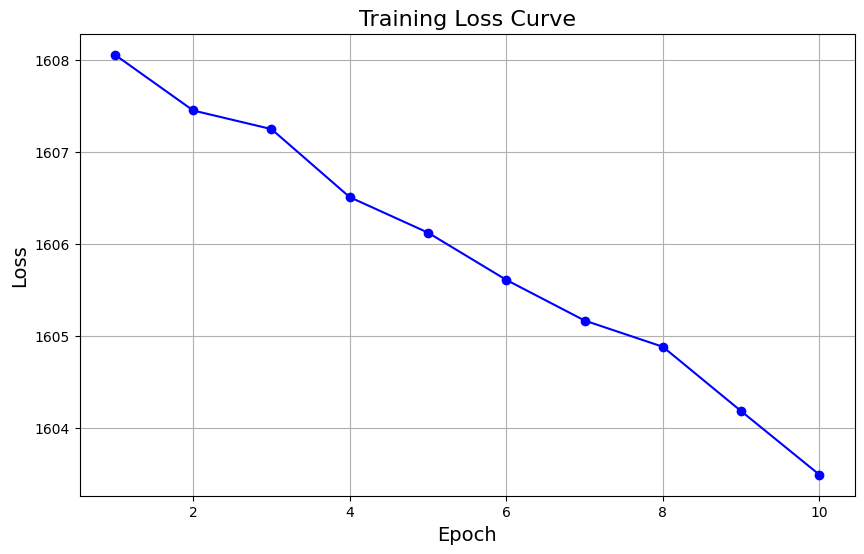

In [ ]:
# Example Usage
dataset = TwitterDataset(df)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Model Parameters
input_size = tweets_tfidf.shape[1] + hashtags_tfidf.shape[1] + 1  # TF-IDF features + encoded user
conv_filters = 32
dense_units = 64
num_classes = 5
learning_rate = 0.001
num_epochs = 10

model = TH_DCNN(input_size=input_size, conv_filters=conv_filters, dense_units=dense_units, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Rank influencers
rankings = rank_influencers(model, dataloader)
print("Influencer Rankings:", rankings)

# Plot the loss curve
plot_loss_curve(epoch_losses)